In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from ParticleTracer import ParticleTracer
from particleTracerLattice import ParticleTracerLattice

In [2]:
lattice = ParticleTracerLattice(200.0)
fileBend1='benderSeg1.txt'
fileBend2 = 'benderSeg2.txt'
fileBender1Fringe='benderFringeCap1.txt'
fileBenderInternalFringe1='benderFringeInternal1.txt'
fileBender2Fringe='benderFringeCap2.txt'
fileBenderInternalFringe2='benderFringeInternal2.txt'
file2DLens='lens2D.txt'
file3DLens='lens3D.txt'
fileCombiner='combinerData.txt'
yokeWidth=.0254*5/8
numMagnets=110
extraSpace=1e-3
Lm=.0254
rp=.0125
Llens1=.3
rb=1.0

lattice.add_Lens_Sim_With_Caps(file2DLens, file3DLens, Llens1)
lattice.add_Combiner_Sim(fileCombiner)
lattice.add_Lens_Sim_With_Caps(file2DLens, file3DLens, Llens1)
lattice.add_Bender_Sim_Segmented_With_End_Cap(fileBend1,fileBender1Fringe,fileBenderInternalFringe1,Lm,None,rb,extraSpace,yokeWidth)
lattice.add_Lens_Sim_With_Caps(file2DLens, file3DLens, None)
lattice.add_Bender_Sim_Segmented_With_End_Cap(fileBend2,fileBender2Fringe, fileBenderInternalFringe2, Lm, None, rb, extraSpace,yokeWidth)
lattice.end_Lattice()
particleTracer=ParticleTracer(lattice)
#lattice.show_Lattice()

1.0 0.5 -0.1


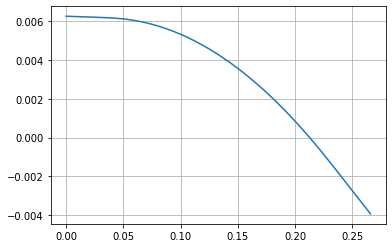

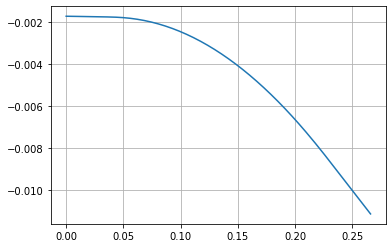

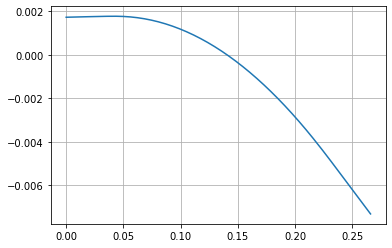

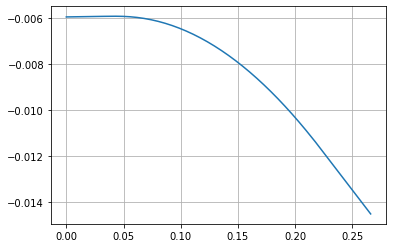

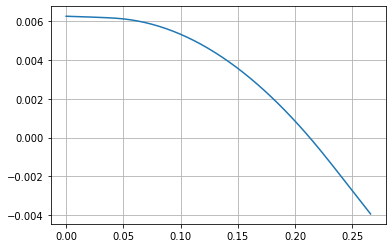

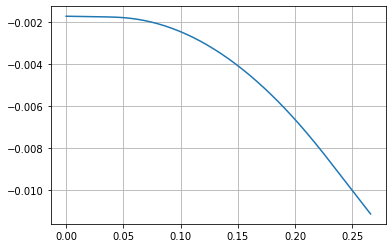

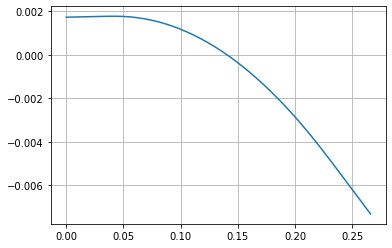

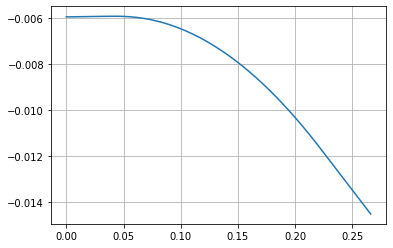

In [19]:
import numpy as np
from ParticleClass import Particle
import scipy.optimize as spo
from elementPT import CombinerSim
import numpy.linalg as npl
import time
import pathos as pa


class Swarm:
    def __init__(self):
        self.particles = []
        self.Lm = None  # length of shaping magnet

    def add_Particle(self, qi, pi):
        self.particles.append(Particle(qi, pi))

    def survival(self, frac=True):
        numSurvived = 0.0
        for particle in self.particles:
            numSurvived += float(not particle.clipped)
        if frac == True:
            return numSurvived / len(self.particles)
        else:
            return numSurvived


class Optimizer:
    def __init__(self, lattice):
        self.lattice = lattice

    def initialize_Swarm_In_Phase_Space(self, qMax, pMax, num):
        # create a cloud of particles in phase space at the origin. In the xy plane, the average velocity vector points
        # to the west.
        qArr = np.linspace(-qMax, qMax, num=num)
        pArr = np.linspace(-pMax, pMax, num=num)
        argsArr = np.asarray(np.meshgrid(qArr, qArr, pArr, pArr)).T.reshape(-1, 4)
        swarm = Swarm()
        # qi=np.asarray([0.0,0.0,0.0])
        # pi=np.asarray([-200.0,0,0])
        # swarm.append(Particle(qi,pi))
        for arg in argsArr:
            qi = np.asarray([0.0, arg[0], arg[1]])
            pi = np.asarray([-self.lattice.v0Nominal, arg[2], arg[3]])
            swarm.add_Particle(qi, pi)
        return swarm

    def send_Swarm_Through_Shaper(self, swarm, Lo, Li, Bp=.5, rp=.03):
        # models particles traveling through an injecting element, which is a simple ideal magnet. This model
        # has the object at the origin and the lens at y=0 and x>0. Particles end up on the output of the lens
        # for now a thin lens
        # particleList: list of particles to transform through the lens.
        # Lo: object distance for injector
        # Li: nominal image distance
        K = 2 * self.lattice.u0 * Bp / (rp ** 2 * self.lattice.v0Nominal ** 2)

        # now find the magnet length that gives Li. Need to parametarize each entry of the transfer matrix.
        # The transfer matrix is for angles, not velocity
        CFunc = lambda x: np.cos(np.sqrt(K) * x)
        SFunc = lambda x: np.sin(np.sqrt(K) * x) / np.sqrt(K)
        CdFunc = lambda x: -np.sqrt(K) * np.sin(np.sqrt(K) * x)
        SdFunc = lambda x: np.cos(np.sqrt(K) * x)
        LiFunc = lambda x: -(CFunc(x) * Lo + SFunc(x)) / (CdFunc(x) * Lo + SdFunc(x))
        minFunc = lambda x: (LiFunc(x) - Li) ** 2
        sol = spo.minimize_scalar(minFunc, method='bounded', bounds=(.1, .5))
        Lm = sol.x
        swarm.Lm = Lm
        MLens = np.asarray([[CFunc(Lm), SFunc(Lm)], [CdFunc(Lm), SdFunc(Lm)]])
        MLo = np.asarray([[1, Lo], [0, 1]])
        MLi = np.asarray([[1, Li], [0, 1]])
        MTot = MLi @ MLens @ MLo
        for particle in swarm.particles:
            qNew = particle.q.copy()
            pNew = particle.p.copy()
            # the v0Nominal is present because the matrix is for angles, not velocities
            qNew[1] = MTot[0, 0] * particle.q[1] + MTot[0, 1] * particle.p[1] / self.lattice.v0Nominal
            pNew[1] = MTot[1, 0] * particle.q[1] * self.lattice.v0Nominal + MTot[1, 1] * particle.p[1]
            qNew[2] = MTot[0, 0] * particle.q[2] + MTot[0, 1] * particle.p[2] / self.lattice.v0Nominal
            pNew[2] = MTot[1, 0] * particle.q[2] * self.lattice.v0Nominal + MTot[1, 1] * particle.p[2]
            particle.q = qNew
            particle.p = pNew
        return swarm

    def initialize_Swarm_At_Combiner_Output(self, Li, Lo, LOffset, qMax, pMax, num):
        # this method generates a cloud of particles in phase space at the output of the combiner.
        # Here the output refers to the origin in the combiner's reference frame.
        # M: magnification of injector lens
        # LOffset: length that the image distance is offset from the combiner output. Positive
        # value corresponds coming to focus before the output (ie, inside the combiner), negative
        # is after the output.
        print(Li, Lo, LOffset)
        if self.lattice.combiner.Lo * 2 > Li:
            raise Exception("IMAGE LENGTH IS TOO SHORT")
        if LOffset > self.lattice.combiner.Lo / 2:
            raise Exception("OFFSET IS TOO DEEP INTO THE COMBINER WITH THE CURRENT ALGORITHM")
        swarm = self.initialize_Swarm_In_Phase_Space(qMax, pMax, num)
        swarm = self.send_Swarm_Through_Shaper(swarm, Lo, Li)
        swarm = self.aim_Swarm_At_Combiner(swarm, Li, LOffset)

        for particle in swarm.particles:
            self.step_Particle_Through_Combiner(particle)
        return swarm

    def step_Particle_Through_Combiner(self, particle, h=1e-5):
        q = particle.q.copy()
        p = particle.p.copy()
        dx = (self.lattice.combiner.space * 2 + self.lattice.combiner.Lm) - q[0]
        dt = dx / p[0]
        q += dt * p
        
        force = self.lattice.combiner.force
        ap = self.lattice.combiner.ap
        apz = self.lattice.combiner.apz

        def is_Clipped(q):
            if np.abs(q[2]) > apz:
                return True
            elif q[0] < self.lattice.combiner.space + self.lattice.combiner.Lm and np.abs(q[1]) > ap:
                return True
        if is_Clipped(q) == True:
            particle.finished()
            particle.clipped = True
            return
        while (True):
            if particle.force is not None:
                F = particle.force
            else:
                F = -force(q)  # force is negatice for high field seeking
            q_n = q + p * h + .5 * F * h ** 2
            if q_n[0] < 0:  # if overshot, go back and walk up to the edge assuming no force
                dr = - q[0]
                dt = dr / p[0]
                q = q + p * dt
                particle.q = q
                particle.p = p
                particle.log_Params()
                break
            F_n = -force(q_n)  # force is negative for high field seeking
            p_n = p + .5 * (F + F_n) * h
            q = q_n
            p = p_n
            particle.force = F_n
            particle.q = q
            particle.p = p
            particle.log_Params()
            if is_Clipped(q) == True:
                particle.finished()
                particle.clipped = True
                return
        particle.finished()
        particle.clipped = False
        #plt.plot(particle.qArr[:,0],particle.qArr[:,1])
        #plt.grid()
        #plt.show()

    def aim_Swarm_At_Combiner(self, swarm, Li, LOffset):
        # This method takes a swarm in phase space, located at the origin, and moves it in phase space
        # so momentum vectors point at the combiner input
        # swarm: swarm of particles in phase space. must be centered at the origin in space
        # Li: the image length, only makes sense for hard edge model
        # LiOffset: image offset in combiner. see initialize_Swarm_At_Combiner_Output
        inputOffset = self.lattice.combiner.inputOffsetLoad
        inputAngle = self.lattice.combiner.angLoad
        dL = Li - self.lattice.combiner.Lo + LOffset  # TODO: SHITTY ALGORITHM THAT NEEDS TO CHANGE. doesn't account
        # for curvature of trajectory. This is the length outside of the combiner
        dx = self.lattice.combiner.space * 2 + self.lattice.combiner.Lm
        dy = inputOffset
        dx += dL * np.cos(inputAngle)
        dy += dL * np.sin(inputAngle)
        dR = np.asarray([dx, dy])
        rotAng = -inputAngle
        rotMat = np.asarray([[np.cos(rotAng), np.sin(rotAng)], [-np.sin(rotAng), np.cos(rotAng)]])
        for particle in swarm.particles:
            q = particle.q
            p = particle.p
            q[:2] += dR
            p[:2] = rotMat @ p[:2]
            particle.q = q
            particle.p = p
        return swarm

    def compute_Survival_Through_Injector(self, Li, Lo, LOffset, qMax, pMax, num):
        swarm = self.initialize_Swarm_At_Combiner_Output(Li, Lo, LOffset, qMax, pMax, num)
        return swarm.survival()

    def maximize_Survival_Through_Injector(self, qMax, pMax, numPhaseSpace, num=50):
        LiMin = 1.0
        LiMax = 2.0
        LoMin = .15
        LoMax = .4
        LOffset = 0.0

        def func(X):
            Li, Lo = X
            return [self.compute_Survival_Through_Injector(Li, Lo, LOffset, qMax, pMax, numPhaseSpace), X]

        x1Arr = np.linspace(LiMin, LiMax, num=num)
        x2Arr = np.linspace(LoMin, LoMax, num=num)

        pool = pa.pools.ProcessPool(nodes=pa.helpers.cpu_count())  # pool object to distribute work load
        jobs = []  # list of jobs. jobs are distributed across processors
        results = []  # list to hold results of particle tracing.
        argsArr = np.asarray(np.meshgrid(x1Arr, x2Arr)).T.reshape(-1, 2)

        for arg in argsArr:
            jobs.append(pool.apipe(func, arg))  # create job for each argument in arglist, ie for each particle
        for job in jobs:
            results.append(job.get())  # get the results. wait for the result in order given
        survivalList=[]
        for result in results:
            survivalList.append(result[0])
        survivalArr=np.asarray(survivalList)
        print(survivalArr)
        print(np.max(survivalArr))


def main():
    optimizer = Optimizer(lattice)
    optimizer.maximize_Survival_Through_Injector(2.5e-4,3e1,5,num=10)
    
if __name__ == '__main__':
    main()




In [4]:
15.374*.008582

0.13193966799999998